## In this notebook, we will
1. Vary the NN architecture to reduce the number of learning parameters.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import statsmodels.api as sm
import time
import os

In [10]:
#Keras/TensorFlow
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Softmax
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

#Keras image processing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [11]:
#Sklearn tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Keras specials
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

## Load csv files into DataFrames
Data was previously split into training and testing sets in <font color='blue'>1.MolRedPot_FeatureEngineering.ipynb</font>

In [4]:
features=pd.read_csv('Data/features_train_scaled.csv')
target=pd.read_csv('Data/target_train.csv',index_col=0)['ERed']

In [5]:
features=tf.convert_to_tensor(features,dtype=tf.float64)
target=tf.convert_to_tensor(target,dtype=tf.float64)

In [6]:
print('Feature matrix shape: ',features.shape)
print('Target property shape: ',target.shape)

Feature matrix shape:  (4353, 32)
Target property shape:  (4353,)


In [7]:
num_dens_layers=4
n_nodes=[64,32,16, 1]
learning_rate=1e-3

model = Sequential()
model.add(Dense(n_nodes[0], kernel_initializer='normal',input_dim = features.shape[1], activation='relu')) # first hidden layer
# model.add(Dropout(0.5))
for i in range(1,num_dens_layers): # loop through the rest of hidden layers
    model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu'))    

model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


## For this NN architecture, the number of trainable parameters is 4737, which is comaprable to 4353 datapoints in the training set.

Epoch 1/50
58/58 [==============================] - 2s 8ms/step - loss: 0.8804 - mean_absolute_error: 0.8804 - val_loss: 0.2103 - val_mean_absolute_error: 0.2103 - lr: 0.0010
Epoch 2/50
58/58 [==============================] - 0s 4ms/step - loss: 0.1537 - mean_absolute_error: 0.1537 - val_loss: 0.1179 - val_mean_absolute_error: 0.1179 - lr: 0.0010
Epoch 3/50
58/58 [==============================] - 0s 4ms/step - loss: 0.1073 - mean_absolute_error: 0.1073 - val_loss: 0.0939 - val_mean_absolute_error: 0.0939 - lr: 0.0010
Epoch 4/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0881 - mean_absolute_error: 0.0881 - val_loss: 0.0832 - val_mean_absolute_error: 0.0832 - lr: 0.0010
Epoch 5/50
58/58 [==============================] - 0s 3ms/step - loss: 0.0787 - mean_absolute_error: 0.0787 - val_loss: 0.0754 - val_mean_absolute_error: 0.0754 - lr: 0.0010
Epoch 6/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0729 - mean_absolute_error: 0.0729 - val_loss: 0.07

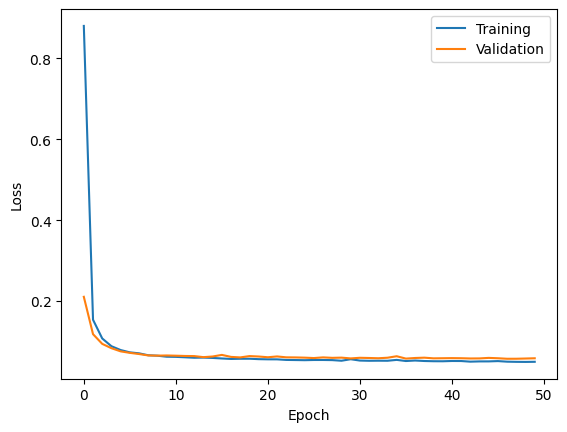

In [12]:
%%time

with tf.device('/cpu:0'):

    redlr=ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.9, patience=5, min_lr=0, verbose=1)

    history=model.fit(features, target, epochs=50, batch_size=64, validation_split = 0.15, callbacks=redlr, verbose=True)

    train_err=history.history['mean_absolute_error']

    val_err=history.history['val_mean_absolute_error']

    plt.figure()
    plt.plot(train_err, label='Training')
    plt.plot(val_err, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

137/137 [==============================] - 0s 2ms/step


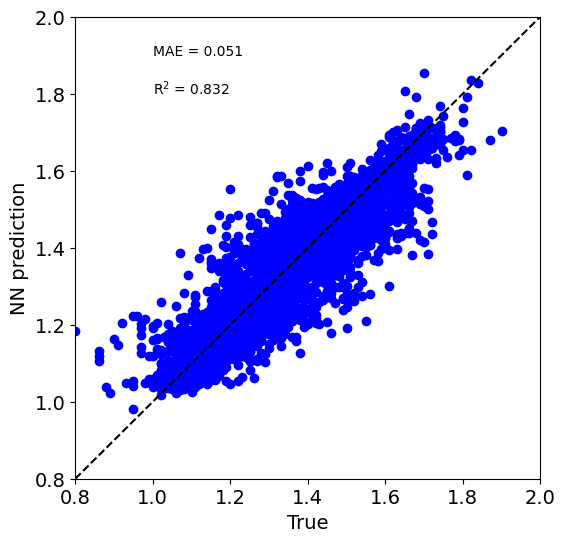

In [13]:
target_nn=model.predict(features)
train_mae=mean_absolute_error(target,target_nn)
train_rmse=np.sqrt(mean_squared_error(target,target_nn))
train_r2=r2_score(target,target_nn)

plt.figure(figsize=(6,6))
plt.scatter(target,target_nn,c='b')
plt.plot([0.8,2],[0.8,2],ls='--',c='k')
plt.xlim([0.8,2])
plt.ylim([0.8,2])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('True',fontsize=14)
plt.ylabel('NN prediction',fontsize=14)
plt.text(1,1.9,'MAE = '+str(np.round(train_mae,3)))
plt.text(1,1.8,'R$^2$ = '+str(np.round(train_r2,3)))
plt.show()

## Other NN architectures were found to not impact model performance.

## Save NN model

In [14]:
!mkdir -p NN_model
model.save('Models/NN_model/')

INFO:tensorflow:Assets written to: Models/NN_model/assets


In [22]:
os.listdir('Models/NN_model/')

['assets', 'keras_metadata.pb', 'saved_model.pb', 'variables']

In [23]:
NN_model = tf.keras.models.load_model('Models/NN_model/')

# Check its architecture
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


## Save NN model and weights as HDF5

In [24]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In the next notebook, <font color = blue>3b.MolRedPot_NN_LearningRateTuning.ipynb
</font>, we will tune the learning rate in the NN model.